# HR Analytics: Job Change of Data Scientists

A company which is active in Big Data and Data Science wants to hire data scientists among people who successfully pass some courses which conduct by the company. Many people signup for their training. Company wants to know which of these candidates are really wants to work for the company after training or looking for a new employment because it helps to reduce the cost and time as well as the quality of training or planning the courses and categorization of candidates. Information related to demographics, education, experience are in hands from candidates signup and enrollment.

This dataset designed to understand the factors that lead a person to leave current job for HR researches too. By model(s) that uses the current credentials,demographics,experience data we will predict the probability of a candidate to look for a new job or will work for the company, as well as interpreting affected factors on employee decision.

## 1.Data Preprocessing

##### Importing all necessary libraries

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame as D
from pandas import Series as S
import warnings
warnings.filterwarnings('ignore')

##### Path to the file

In [24]:
%cd pfda

(bookmark:pfda) -> C:\Users\User\Desktop\Python for data analyses
C:\Users\User\Desktop\Python for data analyses


##### Reading the file and seperating target value from the feautures

In [25]:
data=pd.read_csv('aug_train.csv',na_values='')
data=data.dropna()
target_class=data['target']
data=data.drop(['target'],axis=1)
data.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8
7,402,city_46,0.762,Male,Has relevent experience,no_enrollment,Graduate,STEM,13,<10,Pvt Ltd,>4,18
8,27107,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,7,50-99,Pvt Ltd,1,46
11,23853,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,5,5000-9999,Pvt Ltd,1,108


##### Preparing data for classification without any special alterations

In [26]:
from sklearn.preprocessing import StandardScaler
non_preprocessed_data=StandardScaler().fit_transform(pd.get_dummies(data))

##### Several modifications in the same data: Purpose is to compare modified model with its initial version

In [27]:
data.experience=pd.cut(data.experience.replace({'>20':21,'<1':0}).astype('float64'),[0,1,5,10,20,np.inf],right=False)
data['last_new_job']=pd.cut(data['last_new_job'].replace({'never':0,'>4':5}).astype('float64'),[0,1,4,np.inf],right=False)
data.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,"[10.0, 20.0)",50-99,Pvt Ltd,"[4.0, inf)",47
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,"[20.0, inf)",50-99,Funded Startup,"[4.0, inf)",8
7,402,city_46,0.762,Male,Has relevent experience,no_enrollment,Graduate,STEM,"[10.0, 20.0)",<10,Pvt Ltd,"[4.0, inf)",18
8,27107,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,"[5.0, 10.0)",50-99,Pvt Ltd,"[1.0, 4.0)",46
11,23853,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,"[5.0, 10.0)",5000-9999,Pvt Ltd,"[1.0, 4.0)",108


##### Class weights in target column: Purpose is to set this ratio in Machine Learning Algorithm

In [28]:
target_class.value_counts()

0.0    7472
1.0    1483
Name: target, dtype: int64

##### Preparing Train and Test datasets of non_preprocessed data

In [29]:
from sklearn.model_selection import train_test_split
x_train0,x_test0,y_train0,y_test0=train_test_split(non_preprocessed_data,target_class,random_state=42,test_size=0.2)

##### Importing all necessary metrics

In [30]:
from sklearn.metrics import roc_curve,roc_auc_score,f1_score
from sklearn.metrics import accuracy_score as acc_score

## 2.Building and comparing models in terms of preprocessing

##### Training and evaluating non_preprocessed model (model0) with XGBClassifier: 
Parameters have been picked in terms of best quality of the model

In [31]:
import xgboost as xgb
model0 = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree=0.3, learning_rate = 0.05,
                max_depth=30, alpha=500,gamma=0.05, min_child_weight=3, n_estimators = 200, seed=42,scale_pos_weight=5,verbosity=0)
model0.fit(x_train0,y_train0)
print('AUC score: ',roc_auc_score(y_test0,S(model0.predict_proba(x_test0)[:,1])))

AUC score:  0.7443556774132553


##### Evaluating model with accuracy

In [32]:
S([acc_score(y_train0,model0.predict(x_train0))]+[acc_score(y_test0,model0.predict(x_test0))],index=['Train_acc','Test_acc'])

Train_acc    0.861809
Test_acc     0.856505
dtype: float64

It's obvious that model is trained pretty well and there is nothing about underfitting or overfitting here, but however the best value of AUC score is 0.74. Simply put this model can't be used

-------------------------------------------------------------------------------------------------------------------------------

##### Building and evaluating the preprocessed model

In [33]:
preprocessed_data = StandardScaler().fit_transform(pd.get_dummies(data))

In [34]:
from sklearn.model_selection import StratifiedShuffleSplit as sss  # This helps to split the dataset in two parts retaining initial ratio                                  
split=sss(n_splits=20,test_size=0.2,random_state=42)                                      
for train_index, test_index in split.split(preprocessed_data,target_class):
    x_train1 = D(preprocessed_data).loc[train_index]
    x_test1 = D(preprocessed_data).loc[test_index] 
target_class1 = target_class
target_class1.index = np.arange(0,target_class.shape[0])
y_train1 = target_class1[train_index]
y_test1 = target_class1[test_index]
y_train1.value_counts() # Ratio here is the same as in the whole data(1:5)

0.0    5978
1.0    1186
Name: target, dtype: int64

In [35]:
model1= xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree=0.3, learning_rate = 0.05,
                max_depth=30, alpha=4,gamma=0.05,min_child_weight=3, n_estimators = 200, seed=42,scale_pos_weight=5,verbosity=0)
model1.fit(x_train1,y_train1)
print('AUC score: ',roc_auc_score(y_test1,S(model1.predict_proba(x_test1)[:,1])))

AUC score:  0.8081596870084153


Now it's obvious that preprocessed dataset is way more accurate, than the non_preprocessed one. AUC score here is higher by nearly 10%

------------------------------------------------------------------------------------------------------------------------------

##### Evaluation with accuracy

In [36]:
S([acc_score(y_train1,model1.predict(x_train1))]+[acc_score(y_test1,model1.predict(x_test1))],index=['Train_acc','Test_acc'])

Train_acc    0.927973
Test_acc     0.860972
dtype: float64

We can see that accuracy is roughly the same as in previous model but the model itself is far more stable

----------------------------------------------------------------------------------------------------------------------------

##### Plotting ROC curves of above-mentioned models

In [37]:
s0=S(model0.predict_proba(x_test0)[:,1])
s1=S(model1.predict_proba(x_test1)[:,1])
fpr0, tpr0, thresholds0 = roc_curve(y_test0,s0)
fpr1, tpr1, thresholds1 = roc_curve(y_test1,s1)

Text(0.5, 1.0, 'ROC curves in terms of preprocesing')

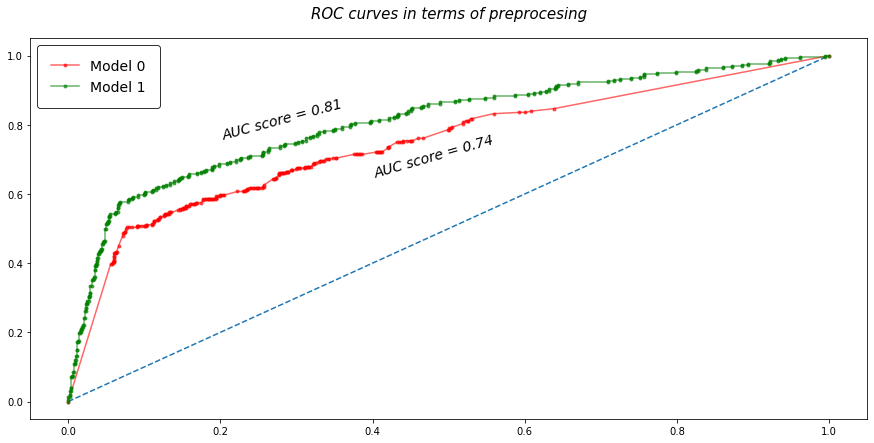

In [38]:
plt.figure(figsize=(15,7))
plt.plot([0,1], [0,1], linestyle='--')
plt.plot(fpr0, tpr0, marker='.', label='Model 0',c='r',alpha=0.6)
plt.plot(fpr1, tpr1, marker='.', label='Model 1',c='g',alpha=0.6)
plt.legend(borderpad=1,fontsize=14,loc='best',edgecolor='k')
plt.text(x=0.2,y=0.76,s='AUC score = 0.81',rotation=15,fontsize=14,fontstyle='italic')
plt.text(x=0.4,y=0.65,s='AUC score = 0.74',rotation=16,fontsize=14,fontstyle='italic')
plt.title('ROC curves in terms of preprocesing',fontsize=15,pad=20,fontstyle='italic')

Thus we ascertained that it'll be prudent to move forward with the second model, because it's performance is much better

------------------------------------------------------------------------------------------------------------------------------

##### The most important features

In [39]:
S(model1.feature_importances_,index=pd.get_dummies(data).columns).sort_values(ascending=False)[:10]

city_city_21              0.290509
city_city_11              0.045854
city_development_index    0.034168
city_city_74              0.029197
city_city_78              0.021698
city_city_101             0.021533
city_city_145             0.018631
city_city_128             0.016270
city_city_103             0.015548
city_city_105             0.014475
dtype: float32

In [40]:
S(model1.feature_importances_,index=pd.get_dummies(data).columns).sort_values(ascending=False)[
                                                             pd.get_dummies(data).columns.str.contains('city')].sum()

0.6753224

These numbers represent the importances of the features. For example 29% of all splittings were performed using the feature 'City_21'. And on the whole we can easily single out 2 most important features covering about 68% of all the splittings. These features are 'City' and 'City developement index'.So we can infer, that the main factor which have impact on the worker's decision about staying or leaving is the location of the company.

-------------------------------------------------------------------------------------------------------------------------------

## 3. Building and comparing models in terms of the number of columns

As we already ascertained, the most important feautures of the dataset are "city" and "city_developement_index". We can try to build a model using only 2 these columns. I suppose the result will only slightly differ compared with the last model.

In [41]:
data.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,"[10.0, 20.0)",50-99,Pvt Ltd,"[4.0, inf)",47
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,"[20.0, inf)",50-99,Funded Startup,"[4.0, inf)",8
7,402,city_46,0.762,Male,Has relevent experience,no_enrollment,Graduate,STEM,"[10.0, 20.0)",<10,Pvt Ltd,"[4.0, inf)",18
8,27107,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,"[5.0, 10.0)",50-99,Pvt Ltd,"[1.0, 4.0)",46
11,23853,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,"[5.0, 10.0)",5000-9999,Pvt Ltd,"[1.0, 4.0)",108


##### Preparing features

In [42]:
cut_data=data.iloc[:,[1,2]]
preprocessed_cut_data=StandardScaler().fit_transform(pd.get_dummies(cut_data))
preprocessed_cut_data.shape    # Number of columns is 117 because we use dummy variables and 'city' column has 116 unique values

(8955, 117)

##### Fulfiling train-test splitting and training the model

In [43]:
split=sss(n_splits=20,test_size=0.2,random_state=42)                                      
for train_index, test_index in split.split(preprocessed_cut_data,target_class):
    x_train2 = D(preprocessed_cut_data).loc[train_index]
    x_test2 = D(preprocessed_cut_data).loc[test_index] 
target_class2 = target_class
target_class2.index = np.arange(0,target_class.shape[0])
y_train2 = target_class2[train_index]
y_test2 = target_class2[test_index]
model2= xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree=1, learning_rate = 0.02,
                max_depth=5, alpha=0.01,gamma=0,min_child_weight=3, n_estimators = 400, seed=42,scale_pos_weight=5,verbosity=0)
model2.fit(x_train2,y_train2)
roc_auc_score(y_test2,S(model2.predict_proba(x_test2)[:,1]))

0.7957509048539838

As anticipated,the quality of this model is rougly the same, but its performence is slightly worse. However this fact indicates, that target value can't be fully described by current varibales, because there are only 2-3 factors that really have any impact on it. So on the one hand for further research we can collect only information about above features, neglecting the others. And on the other hand we can try to find out more versatile and diverse information that can help to improve accuracy.

In [44]:
S([acc_score(y_train2,model2.predict(x_train2))]+[acc_score(y_test2,model2.predict(x_test2))],index=['Train_acc','Test_acc'])

Train_acc    0.843663
Test_acc     0.860972
dtype: float64

Accuracy is also the same, and if we just use this model for our predictions, we won't lose too much

---------------------------------------------------------------------------------------------------------------------------

##### Plotting ROC curves

Text(0.5, 1.0, 'ROC curves in terms of the numbers of columns')

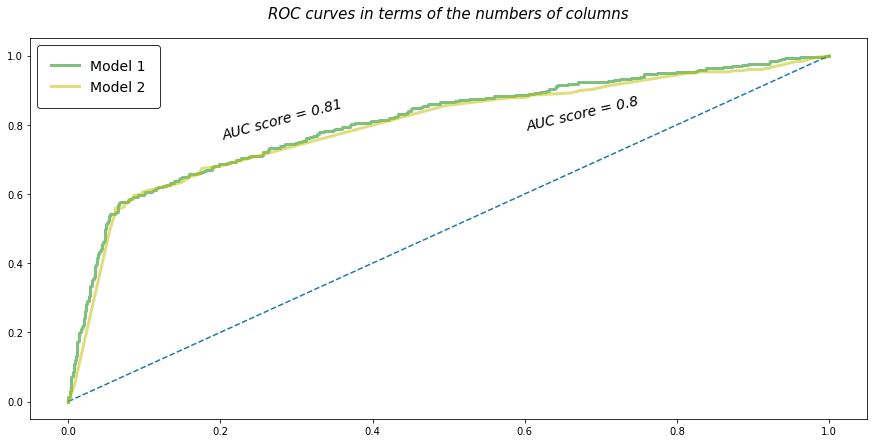

In [45]:
s2=S(model2.predict_proba(x_test2)[:,1])
fpr2, tpr2, thresholds2 = roc_curve(y_test2,s2)
plt.figure(figsize=(15,7))
plt.plot([0,1], [0,1], linestyle='--')
plt.plot(fpr1, tpr1, label='Model 1',c='g',alpha=0.5,lw=3)
plt.plot(fpr2, tpr2, label='Model 2',c='y',alpha=0.5,lw=3)
plt.legend(borderpad=1,fontsize=14,loc='best',edgecolor='k')
plt.text(x=0.2,y=0.76,s='AUC score = 0.81',rotation=15,fontsize=14,fontstyle='italic')
plt.text(x=0.6,y=0.785,s='AUC score = 0.8',rotation=13,fontsize=14,fontstyle='italic')
plt.title('ROC curves in terms of the numbers of columns',fontsize=15,pad=20,fontstyle='italic')

-----------------------------------------------------------------------------------------------------------------------------

Sometimes, reduction of the number of non-informative variables may lead to an increase in quality. Let's try this reducing the number of our columns from 158 to 140, retaining the most informative ones

##### Labels of 140 most important variables

In [46]:
new_columns=S(model1.feature_importances_,index=pd.get_dummies(data).columns).sort_values(ascending=False)[:140].index.values
new_columns[:10]

array(['city_city_21', 'city_city_11', 'city_development_index',
       'city_city_74', 'city_city_78', 'city_city_101', 'city_city_145',
       'city_city_128', 'city_city_103', 'city_city_105'], dtype=object)

##### Preparations

In [47]:
cut_data1=pd.get_dummies(data).loc[:,new_columns]
preprocessed_cut_data1=StandardScaler().fit_transform(cut_data1)
split=sss(n_splits=20,test_size=0.2,random_state=42)                                      
for train_index, test_index in split.split(preprocessed_cut_data1,target_class):
    x_train3 = D(preprocessed_cut_data1).loc[train_index]
    x_test3 = D(preprocessed_cut_data1).loc[test_index] 
target_class3 = target_class
target_class3.index = np.arange(0,target_class.shape[0])
y_train3 = target_class3[train_index]
y_test3 = target_class3[test_index]

##### Model training

In [48]:
model3= xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree=0.1, learning_rate = 0.05,
                max_depth=10, alpha=1,gamma=0.05,min_child_weight=3, n_estimators = 300, seed=42,scale_pos_weight=5,verbosity=0)
model3.fit(x_train3,y_train3)
roc_auc_score(y_test3,S(model3.predict_proba(x_test3)[:,1]))

0.811213428348636

As we can see,the result is slightly better than in the case of 158 columns, but this is not a sufficient improvement to unequivoclly choose this model.

##### Accuracy

In [49]:
S([acc_score(y_train3,model3.predict(x_train3))]+[acc_score(y_test3,model3.predict(x_test3))],index=['Train_acc','Test_acc'])

Train_acc    0.882607
Test_acc     0.855946
dtype: float64

This result is far more better than in model1, because AUC score here reaches its maximum without overfitting, but simultaneously it preserves roughly the same accuracy on the test-set. So the reduction of 18 columns is a good idea and we'll use it in our subsequent research.

-------------------------------------------------------------------------------------------------------------------------------

## 4. Other  algorithms in use

##### Getting rid of class_weight problem

As some of our subsequent models don't have class_weight parameter, it seems reasonable to settle class-disbalance manually. We'll do it simply adding duplicates to the existing training set.

In [50]:
ones_predictors=D(x_train3[y_train3==1])
ones_targets=S(y_train3[y_train3==1])
balanced_data=D(x_train3)
balanced_target=S(y_train3)
proportions=target_class.value_counts().sort_index(ascending=False)
for i in range(0,int(round(proportions[0]/proportions[1],0))-1):
    balanced_data=pd.concat([balanced_data,ones_predictors],axis=0,ignore_index=True)
    balanced_target=pd.concat([balanced_target,ones_targets],axis=0,ignore_index=True)
balanced_target.value_counts()

0.0    5978
1.0    5930
Name: target, dtype: int64

#### Random Forest Classifier 
Here we will use it via CalibratedClassifier to get its predictions as probabilities. It will help to get the most accurate value of AUC score. We also will use dataset with reduced columns that we get via feature importances

In [51]:
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.calibration import CalibratedClassifierCV
model_rfc = rfc(n_estimators=170,random_state=42,max_depth=14,min_samples_split=10)
calibrator_rfc = CalibratedClassifierCV(model_rfc,cv=2,method='sigmoid')
calibrator_rfc.fit(balanced_data,balanced_target)
s_rfc = S(calibrator_rfc.predict_proba(x_test3)[:,1])
fpr_rfc,tpr_rfc,thresholds_rfc = roc_curve(y_test3,s_rfc)
print('AUC Score: ',roc_auc_score(y_test3,s_rfc))

AUC Score:  0.7957013238137736


It was evident, that AUC score here would be worse than in XGB. However this is not a bad model to use. Moreover we will use this in Stacking and Voting Classifiers, becuase I suppose there can be certain difference between the results of XGB and RF.

------------------------------------------------------------------------------------------------------------------------------

In [52]:
S([acc_score(y_train3,calibrator_rfc.predict(x_train3))]+[acc_score(y_test3,calibrator_rfc.predict(x_test3))],index=['Train_acc','Test_acc'])

Train_acc    0.879397
Test_acc     0.862088
dtype: float64

Accuracy score is slightly better here, but we should keep in mind that our classes are very imbalanced and high accuracy on  test-set may  indicate that the model neglects positive targets training and making predictions relying only on negatives. We use accuracy scores here mostly to prevent overfitting and pick good parameters faster. 

--------------------------------------------------------------------------------------------------------------------------

#### Gradient Boosting Machine

In [53]:
from sklearn.ensemble import GradientBoostingClassifier as gbc
model_gbc = gbc(n_estimators=60,random_state=42,max_depth=8,min_samples_split=10,learning_rate=0.05)
calibrator_gbc = CalibratedClassifierCV(model_gbc,cv=2,method='sigmoid')
calibrator_gbc.fit(balanced_data,balanced_target)
calibrator_gbc.predict_proba(x_test3)
s_gbc = S(calibrator_gbc.predict_proba(x_test3)[:,1])
fpr_gbc,tpr_gbc,thresholds_gbc = roc_curve(y_test3,s_gbc)
print('AUC Score: ',roc_auc_score(y_test3,s_gbc))

AUC Score:  0.792734349293921


In [54]:
S([acc_score(y_train3,calibrator_gbc.predict(x_train3))]+[acc_score(y_test3,calibrator_gbc.predict(x_test3))],index=['Train_acc','Test_acc'])

Train_acc    0.884283
Test_acc     0.850921
dtype: float64

Result is give or take the same as in the case of Random Forest, but still worse than XBG

------------------------------------------------------------------------------------------------------------------------------

##### Neural networks
We will use DL model here, which can't compile with sklearn algorithms under natural circumstances, but with several tools we can make it a sklearn classifier and use with the others in Stacking or Voting classifiers.

In [55]:
import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
tf.random.set_seed(12345)
init1=keras.initializers.TruncatedNormal(mean=0,stddev=0.05) # Setting initialization parameters
init2=keras.initializers.Constant(0)
reg1=keras.regularizers.l1(0.0005)
reg2=keras.regularizers.l1(0)
model_nn=Sequential()
model_nn.add(Dense(10,input_dim=140,activation='relu',kernel_initializer=init1,bias_initializer=init2,kernel_regularizer=reg1,bias_regularizer=reg2))
model_nn.add(Dense(1,activation='sigmoid',kernel_initializer=init1,bias_initializer=init2,kernel_regularizer=reg1,bias_regularizer=reg2))
model_nn.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
history=model_nn.fit(balanced_data.values,balanced_target.values,epochs=3,validation_split=0.1,verbose=2)

Epoch 1/3
335/335 - 4s - loss: 0.6209 - accuracy: 0.7258 - val_loss: 0.6389 - val_accuracy: 0.5768
Epoch 2/3
335/335 - 1s - loss: 0.5488 - accuracy: 0.7544 - val_loss: 0.6459 - val_accuracy: 0.5802
Epoch 3/3
335/335 - 0s - loss: 0.5420 - accuracy: 0.7580 - val_loss: 0.6481 - val_accuracy: 0.5928


In [56]:
print('AUC Score: ',roc_auc_score(y_test3,S(model_nn.predict_proba(x_test3)[:,0])))

AUC Score:  0.796665900414227


In [57]:
S([model_nn.evaluate(x_train3,y_train3)[1]]+[model_nn.evaluate(x_test3,y_test3)[1]],index=['Train_acc','Test_acc'])

56/56 [==============================] - 0s 2ms/step - loss: 0.4753 - accuracy: 0.8582


Train_acc    0.852317
Test_acc     0.858180
dtype: float64

This is not the best result we can achieve with neural networks, but it doesn't matter, because we don't even need it. All we need is different predictions from different algorithms to use them in Stacking and Voting Classifiers

-------------------------------------------------------------------------------------------------------------------------------

##### Function of Neural Network model parameters
We need this to train KerasClassifier and virtually make the neural network a sklearn classificator

In [58]:
def get_model():
    tf.random.set_seed(12345)
    model=Sequential()
    model.add(Dense(10,input_dim=140,activation='relu',kernel_initializer=init1,bias_initializer=init2,kernel_regularizer=reg1,bias_regularizer=reg2))
    model.add(Dense(1,activation='sigmoid',kernel_initializer=init1,bias_initializer=init2,kernel_regularizer=reg1,bias_regularizer=reg2))
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    return model

##### Training Keras Classifier based on our recent model_nn

In [59]:
from keras.wrappers.scikit_learn import KerasClassifier as kc
model_kc = kc(build_fn=get_model,epochs=3,validation_split=0.1,verbose=0)
model_kc.estimator_type="classifier"
model_kc.fit(balanced_data.values,balanced_target.values)

In [60]:
print('AUC Score: ',roc_auc_score(y_test3,S(model_kc.predict_proba(x_test3)[:,1])))

AUC Score:  0.796665900414227


In [61]:
S([acc_score(y_train3,model_kc.predict(x_train3))]+[acc_score(y_test3,model_kc.predict(x_test3))],index=['Train_acc','Test_acc'])

Train_acc    0.852317
Test_acc     0.858180
dtype: float64

Accuracy and AUC score are the same

So we already have several different algorithms and we can use them to build Stacking and Voting Classifiers trying to increase their performance

## 5. Stacking

Here we will use the outcomes of several already examined models as variables to predict the value of target column. The models are the following: Random Forest, Gradient Boosting, Neural network and XBG

##### One model of each algorithm

In [62]:
#Getting parameters from already trained and optimized models
params_rfc=calibrator_rfc.get_params()
params_nn=model_kc.get_params()
params_xgb=model3.get_params()
#Popping unnecessary parameters
params_nn.pop('build_fn')
params_xgb.pop('scale_pos_weight')
#Models
RandomForest=CalibratedClassifierCV().set_params(**params_rfc)
GradientBoosting=CalibratedClassifierCV().set_params(**calibrator_gbc.get_params())
NeuralNetwork=kc(build_fn=get_model).set_params(**params_nn)
NeuralNetwork._estimator_type="classifier"
XGB=xgb.XGBClassifier().set_params(**params_xgb)

##### Training Stacking Classifier

In [63]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
estimators=[('RandomForest',RandomForest),('XGBoost',XGB),('NeuralNetwork',NeuralNetwork),('GradientBoosting',GradientBoosting)]
model_stack=StackingClassifier(estimators=estimators,final_estimator=LogisticRegression(C=0.00003, random_state=12345),cv=3,verbose=1)
model_stack.fit(balanced_data,balanced_target)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   14.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   18.5s finished


StackingClassifier(cv=3,
                   estimators=[('RandomForest',
                                CalibratedClassifierCV(base_estimator=RandomForestClassifier(max_depth=14,
                                                                                             min_samples_split=10,
                                                                                             n_estimators=170,
                                                                                             random_state=42),
                                                       cv=2)),
                               ('XGBoost',
                                XGBClassifier(alpha=1, base_score=0.5,
                                              booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=0.1, gamma=0.05,
                             

##### Evaluation

In [64]:
print('AUC score: ',roc_auc_score(y_test3,model_stack.predict_proba(x_test3)[:,1]))

AUC score:  0.8071973640916077


In [65]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test3,model_stack.predict(x_test3))

array([[1392,  102],
       [ 127,  170]], dtype=int64)

In [66]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test3,model3.predict(x_test3))

array([[1349,  145],
       [ 113,  184]], dtype=int64)

In [67]:
S([acc_score(y_train3,model_stack.predict(x_train3))]+[acc_score(y_test3,model_stack.predict(x_test3))],index=['Train_acc','Test_acc'])

Train_acc    0.879118
Test_acc     0.872138
dtype: float64

AUC score is slightly worse than in our best model(model3) but if we look at confusion_matrix or at accuracy, we can see that the result is even better here. Precision is far more better and recall is slightly worse. I would  pick this model instead of model3. But we should keep i mind the fact, that we usedd here only 4 models and that's obviously not a sufficient amount of predictors.

## 6. Voting

##### Training Voting Classifier

In [68]:
from sklearn.ensemble import VotingClassifier
model_vote=VotingClassifier(estimators=estimators,voting='soft',verbose=0)
model_vote.fit(balanced_data,balanced_target)

VotingClassifier(estimators=[('RandomForest',
                              CalibratedClassifierCV(base_estimator=RandomForestClassifier(max_depth=14,
                                                                                           min_samples_split=10,
                                                                                           n_estimators=170,
                                                                                           random_state=42),
                                                     cv=2)),
                             ('XGBoost',
                              XGBClassifier(alpha=1, base_score=0.5,
                                            booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=0.1, gamma=0.05,
                                            gpu_id=-1, importance_type='gain',

#### Evaluation

In [69]:
print('AUC score: ',roc_auc_score(y_test3,model_vote.predict_proba(x_test3)[:,1]))

AUC score:  0.8074632987618261


In [70]:
S([acc_score(y_train3,model_vote.predict(x_train3))]+[acc_score(y_test3,model_vote.predict(x_test3))],index=['Train_acc','Test_acc'])

Train_acc    0.880932
Test_acc     0.861530
dtype: float64

In [71]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test3,model_vote.predict(x_test3))

array([[1372,  122],
       [ 126,  171]], dtype=int64)

In [72]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test3,model_stack.predict(x_test3))

array([[1392,  102],
       [ 127,  170]], dtype=int64)

As we can see Voting Classifier is wee bit worse than Stacking. But these 2 models are quite good and can be used, especially for this non-informative dataset

## 7. Pipelines and Test-set

##### Reading test data

In [73]:
test=pd.read_csv('aug_test.csv',na_values='')

##### Class for all the necessary preprocessing and suited for pipeline

In [74]:
from sklearn.base import BaseEstimator, TransformerMixin
class Preprocessing(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self,test):
        train=pd.read_csv('aug_train.csv',na_values='')
        train=train.dropna()
        train.experience=pd.cut(train.experience.replace({'>20':21,'<1':0}).astype('float64'),[0,1,5,10,20,np.inf],right=False)
        train['last_new_job']=pd.cut(train['last_new_job'].replace({'never':0,'>4':5}).astype('float64'),[0,1,4,np.inf],right=False)
        test=test.dropna()
        test_size=test.shape[0]
        test.experience=pd.cut(test.experience.replace({'>20':21,'<1':0}).astype('float64'),[0,1,5,10,20,np.inf],right=False)
        test['last_new_job']=pd.cut(test['last_new_job'].replace({'never':0,'>4':5}).astype('float64'),[0,1,4,np.inf],right=False)
        entire_data=pd.concat([train,test],axis=0,ignore_index=True)
        entire_data=pd.get_dummies(entire_data).loc[:,new_columns]
        self.entire_data=entire_data
        self.test_size=test_size
        return self
    def transform(self,test):
        test_data=self.entire_data.iloc[-self.test_size:,:]
        return test_data

##### Pipeline

In [75]:
from sklearn.pipeline import Pipeline
pipe=Pipeline([('Preprocessing',Preprocessing()),('Std',StandardScaler())])
preprocessed_test_data=pipe.fit(test).transform(test)

##### Predicted values with our best model

In [76]:
S(model_stack.predict(preprocessed_test_data))

0       0.0
1       0.0
2       0.0
3       0.0
4       1.0
       ... 
1014    0.0
1015    1.0
1016    0.0
1017    0.0
1018    0.0
Length: 1019, dtype: float64

## 8. Summary

In [77]:
metrics={}
all_models=estimators+[('Stacking',model_stack),('Voting',model_vote)]
for model_name, model in all_models:
    model.fit(balanced_data,balanced_target)
    metrics[model_name]=[acc_score(y_train3,model.predict(x_train3))]+[acc_score(y_test3,model.predict(x_test3))]+[roc_auc_score(y_test3,model.predict_proba(x_test3)[:,1])]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   13.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   17.6s finished


In [78]:
metrics_df=D(metrics,index=['Train accuracy','Test accuracy','AUC score']).T
metrics_df

,Train accuracy,Test accuracy,AUC score
RandomForest,0.879397,0.862088,0.795701
XGBoost,0.882607,0.855946,0.811213
NeuralNetwork,0.852317,0.858180,0.796666
GradientBoosting,0.884283,0.850921,0.792734
Stacking,0.879118,0.872138,0.807197
Voting,0.880932,0.861530,0.807463
